# Выборка и агрегация данных в MongoDB

###Цель домашней работы

Закрепить на практике основные приемы работы с СУБД MongoDB, включая выборку, сортировку, объединение, агрегацию данных и передачу результатов выборки в программу на Python в целях аналитики и дальнейшей обработки.

### Формулировка задания

В этом задании вам предстоит выполнить несколько запросов к базе данных для получения выборок по условиям, а также воспользоваться фреймворком агрегации MongoDB для построения конвейера обработки данных.

Максимальное количество баллов за выполнение домашней работы: 10.

##Что нужно использовать в работе над заданием

I. MongoDB:

1. Зарегистрируйтесь в сервисе MongoDB Atlas: https://www.mongodb.com/atlas/database.
1. Создайте кластер уровня M0 (это бесплатно).
1. Добавьте в кластер тестовую базу данных `sample_mflix`, используя опцию Load Sample Dataset.

В качестве альтернативы вы можете установить MongoDB на свой локальный компьютер и импортировать необходимые датасеты в свою СУБД, загрузив их по ссылке: https://github.com/neelabalan/mongodb-sample-dataset/tree/main/sample_mflix. Для этого подключитесь к своему серверу через Compass, создайте новую БД, создайте для каждого датасета коллекцию и щелкните «Add data» → «Import JSON or CSV file».

II. MongoDB Compass — в качестве вспомогательного инструмента для конструирования запросов и агрегаций.

III. Python и библиотека pymongo. Работа ведется в Jupyter Notebook или Google Colaboratory. Рекомендуется использовать версию Python 3.12.

##Ожидаемые результаты

Результаты работы необходимо оформить в виде ноутбука Jupyter. Можно загрузить файл в LMS либо поделиться ссылкой на Google Colaboratory.

##Место где нужно выполнить задание



In [10]:
#!pip install pymongo

import pymongo

client = pymongo.MongoClient(
"mongodb://localhost:27017")

print(client.list_database_names())  # Вывести список БД для проверки подключения

['admin', 'config', 'local', 'sample_db']


### Упражнение 1. Запросы на выборку

Цель этого упражнения — закрепить навык выполнения запросов на выборку. Все запросы выполняются на базе `sample_mflix` с данными о кинофильмах.

#### Задача 1.1 — **1 балл**

Выведите из коллекции `theaters` документы о кинотеатрах в городе Florence, штат KY.

Для справки:

* Обратите внимание на то, что информация об адресе кинотеатров хранится во вложенных документах. Для доступа к полям вложенных документов следует использовать точку: `родительский_документ.вложенный_документ.поле`.
* В случае затруднений с написанием логического условия обращайтесь к сопоставлению синтаксиса SQL и Mongo: https://www.mongodb.com/docs/manual/reference/sql-comparison/.
* Если вы предпочитаете сперва выполнять запросы в Compass, из этого приложения можно выгружать код готового запроса на Python (кнопка с символом `</>`).

In [11]:
db = client['sample_db']

florenceKY = db['theaters'].find({
    "location.address.city": "Florence",
    "location.address.state": "KY"
})

for i in florenceKY:
    print(i)


{'_id': ObjectId('59a47287cfa9a3a73e51e893'), 'theaterId': 161, 'location': {'address': {'street1': '100 Meijer Dr.', 'city': 'Florence', 'state': 'KY', 'zipcode': '41042'}, 'geo': {'type': 'Point', 'coordinates': [-84.636383, 39.014843]}}}
{'_id': ObjectId('59a47287cfa9a3a73e51ea02'), 'theaterId': 2823, 'location': {'address': {'street1': '2823 Florence Mall', 'street2': '#2148', 'city': 'Florence', 'state': 'KY', 'zipcode': '41042'}, 'geo': {'type': 'Point', 'coordinates': [-84.6499595, 38.9967246]}}}


#### Задача 1.2 — **1 балл**

Сделав запрос к коллекции `comments`, выведите _один_ комментарий (значение поля `text`) пользователя по имени Doreah.

In [12]:
print(db["comments"].find_one({"name": "Doreah"})['text'])

Porro explicabo cumque vitae sint quia quis. Consequuntur voluptatibus optio maxime ratione temporibus incidunt minus architecto.


#### Задача 1.3 — **1 балл**

Сделав запрос к коллекции `movies`, выведите количество документов, в которых в качестве первого жанра фильма (поле `genres`) указано значение «Horror».

Для справки:

1. Обратите внимание, что поле `genres` представляет собой массив (индексация массивов начинается с нуля).
1. При работе в MongoDB Shell для подсчета количества документов в курсоре можно использовать метод `count()`, однако он был удален в последних версиях библиотеки pymongo. В случае затруднений с использованием функций Mongo можно использовать для подсчета документов средства Python.

In [13]:
print(db['movies'].count_documents({"genres.0": "Horror"}))

814


#### Задача 1.4 — **2 балла**

Выведите из коллекции `movies` документы о фильмах, которые в качестве первого жанра определены как «Film-Noir» либо «Horror» и были выпущены в период с 1940 по 1949 гг. (включительно).

In [14]:
from datetime import datetime

movies = db['movies'].find({
    "$and": [
        {"genres.0": {"$in": ["Film-Noir", "Horror"]}},
        {"released": {"$gte": datetime(1940, 1, 1), "$lte": datetime(1949, 12, 31)}}
    ]
})

for i in movies:
    print(i)

{'_id': ObjectId('573a1393f29313caabcdc814'), 'plot': "An American man marries a Serbian immigrant who fears that she will turn into the cat person of her homeland's fables if they are intimate together.", 'genres': ['Horror', 'Thriller'], 'runtime': 73, 'rated': 'APPROVED', 'cast': ['Simone Simon', 'Kent Smith', 'Tom Conway', 'Jane Randolph'], 'poster': 'https://m.media-amazon.com/images/M/MV5BNzI4YWY0NWQtNWI5YS00MGE4LWE4YTgtMzBmOWIwMzdiYTRiL2ltYWdlL2ltYWdlXkEyXkFqcGdeQXVyNjc1NTYyMjg@._V1_SY1000_SX677_AL_.jpg', 'title': 'Cat People', 'fullplot': 'Irena Dubrovna, a beautiful and mysterious Serbian-born fashion artist living in New York City, falls in love with and marries average-Joe American Oliver Reed. Their marriage suffers though, as Irena believes that she suffers from an ancient curse- whenever emotionally aroused, she will turn into a panther and kill. Oliver thinks that is absurd and childish, so he sends her to psychiatrist Dr. Judd to cure her. Easier said than done...', 'la

#### Задача 1.5 — **1 балл**

Модифицируйте запрос из задачи 1.4 таким образом, чтобы осуществить _проекцию_: результатом выборки должен стать список словарей, каждый из которых содержит только два поля: `title` и `year`.

Для справки о проекции см. документацию по методу `find()` в pymongo:
https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.find

In [15]:
movies2 = db['movies'].find({
    "$and": [
        {"genres.0": {"$in": ["Film-Noir", "Horror"]}},
        {"released": {"$gte": datetime(1940, 1, 1), "$lte": datetime(1949, 12, 31)}}
    ]
}, {"title": 1, "year": 1, "_id": 0})

for i in movies2:
    print(i)

{'title': 'Cat People', 'year': 1942}
{'title': 'I Walked with a Zombie', 'year': 1943}
{'title': 'The Leopard Man', 'year': 1943}
{'title': 'Dead of Night', 'year': 1945}
{'title': 'Spellbound', 'year': 1945}
{'title': 'The Chase', 'year': 1946}
{'title': 'The Set-Up', 'year': 1949}
{'title': 'The Third Man', 'year': 1949}


### Упражнение 2. Конвейер агрегации

#### Задача 2.1 — **3 балла**

В рамках этой задачи требуется узнать, какие фильмы получили наибольшее число комментариев. Составьте для этого конвейер агрегации с перечисленными ниже этапами. Для удобства рекомендуется воспользоваться приложением Compass.

1. Сгруппировать документы коллекции `comments` по полю `movie_id` и подсчитать количество комментариев для каждого фильма, записав его в поле `count`.
1. Отсортировать получившийся набор данных по убыванию количества комментариев (так чтобы первый документ в этом наборе указывал на фильм с наибольшим количеством комментариев).
1. Используя оператор `$lookup`, присоединить коллекцию `movies` (по полю `movie_id`).
1. Выполнить проекцию, оставив в наборе данных только три поля: название фильма (`title`), год выпуска (`year`) и количество комментариев (поле `count`, добавленное на первом этапе). Для этого воспользуйтесь оператором `$project`: https://www.mongodb.com/docs/manual/reference/operator/aggregation/project/. Обратите внимание, что данные из коллекции `movies` (`title` и `year`) на этом этапе окажутся внутри массива.
1. Применить оператор `$unwind`, чтобы деконструировать этот массив. См. https://www.mongodb.com/docs/manual/reference/operator/aggregation/unwind/. В результате массив должен превратиться в одиночный объект.
1. Применить оператор `$addFields`, чтобы добавить поля `title` и `year` на вернхий уровень структуры документа. См. https://www.mongodb.com/docs/manual/reference/operator/aggregation/addFields/.
1. Еще раз выполнить проекцию, чтобы удалить поле с массивом.

Ваш алгоритм решения может отличаться от приведенного здесь. Главное — достичь цели: получить плоский набор данных с тремя полями (`count` — количество комментариев, `year` — год выпуска, `title` — название фильма).

Скопируйте полученный конвейер в этот документ в виде кода на Python и выведите его на экран в виде списка словарей.

In [19]:
pipeline = [
    {
        "$group": {
            "_id": "$movie_id",
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"count": -1}
    },
    {
        "$lookup": {
            "from": "movies",
            "localField": "_id",
            "foreignField": "_id",
            "as": "movie"
        }
    },
    {
        "$project": {
            "count": 1,
            "movie.title": 1,
            "movie.year": 1
        }
    },
    {
        "$unwind": "$movie"
    },
    {
        "$addFields": {
            "title": "$movie.title",
            "year": "$movie.year"
        }
    },
    {
        "$project": {
            "_id": 0,
            "count": 1,
            "title": 1,
            "year": 1
        }
    }
]

res_pipeline = list(db['comments'].aggregate(pipeline))

print(res_pipeline)

[{'count': 161, 'title': 'The Taking of Pelham 1 2 3', 'year': 2009}, {'count': 158, 'title': 'About a Boy', 'year': 2002}, {'count': 158, 'title': 'Terminator Salvation', 'year': 2009}, {'count': 158, 'title': '50 First Dates', 'year': 2004}, {'count': 158, 'title': "Ocean's Eleven", 'year': 2001}, {'count': 157, 'title': 'The Mummy', 'year': 1999}, {'count': 157, 'title': 'Sherlock Holmes', 'year': 2009}, {'count': 155, 'title': 'Hellboy II: The Golden Army', 'year': 2008}, {'count': 154, 'title': 'Anchorman: The Legend of Ron Burgundy', 'year': 2004}, {'count': 154, 'title': 'The Mummy Returns', 'year': 2001}, {'count': 153, 'title': 'Cinderella', 'year': 1950}, {'count': 153, 'title': 'E.T. the Extra-Terrestrial', 'year': 1982}, {'count': 153, 'title': 'Bruce Almighty', 'year': 2003}, {'count': 153, 'title': 'Mission: Impossible', 'year': 1996}, {'count': 153, 'title': "Pirates of the Caribbean: At World's End", 'year': 2007}, {'count': 153, 'title': 'X-Men', 'year': 2000}, {'count

#### Задача 2.2 — **1 балл**

Используя данные, полученные в задаче 2.1, выведите на экран столбчатую диаграмму, показывающую топ-20 наиболее комментируемых фильмов. По оси ординат выведите названия этих фильмов (подписи разместите слева диаграммы), по оси абсцисс — количество комментариев.

Для решения задачи можно использовать любую библиотеку, например Seaborn или Matplotlib.

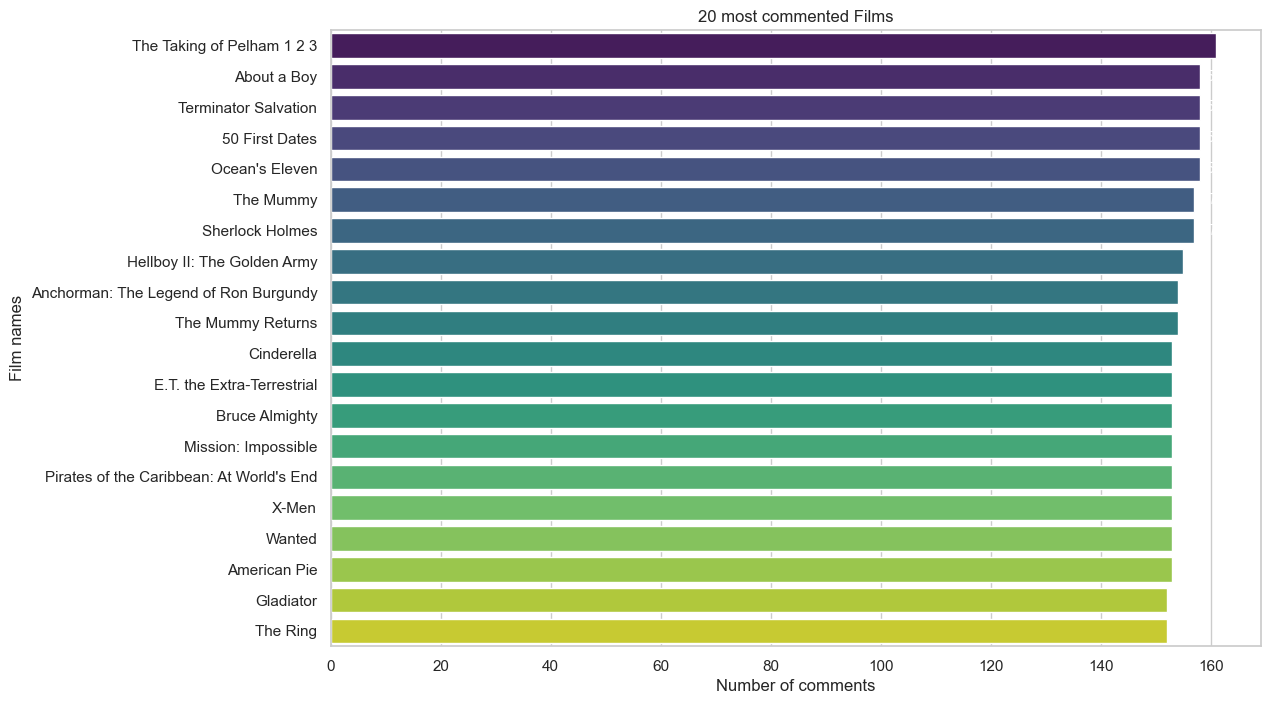

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

res_pipeline_20 = res_pipeline[:20]

y = [i['title'] for i in res_pipeline_20]
x = [i['count'] for i in res_pipeline_20]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

barplot = sns.barplot(x=x, y=y, palette="viridis", hue=y, dodge=False, legend=False)

for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='left', va='center', color='white', fontsize=10)

plt.xlabel('Number of comments')
plt.ylabel('Film names')
plt.title('20 most commented Films')
plt.show()